***Create a synthetic dataset for two particles in a harmonic potential trap, with a Coulomb potential between the two.***

Here we have two particles in 1D. Note the fixed points where the Coulomb repulsion and harmonic potential cancel each other out.

Since the $|q_0-q_1|<.10$ region creates numerical instability as the values for $|\ddot{q}|$ become very large and run into rounding errors, I am discarding any points that fall in this region. 

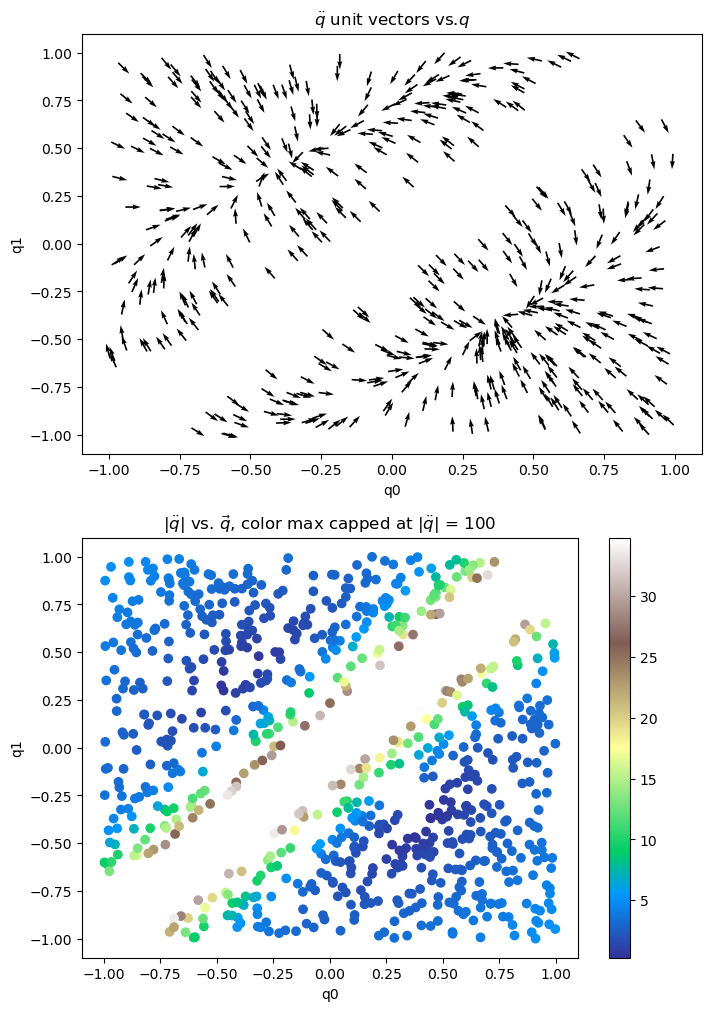

In [271]:
##### import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
import torch
from torch import tensor, sum, log, max

#####
# problem setup

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([4],dtype=torch.float64)
alpha = torch.tensor([1.],dtype=torch.float64) #charge0*charge1

n_points = 1000
q_min = -1
q_max = 1
dist_threshold = 0.20
qdot_min = -1
qdot_max = 1

#####
# function definitions

def L(qv,qdotv,m,k,alpha): #including Coulomb potential
    return sum(0.5*m*qdotv**2) - sum(0.5*k*qv**2) - alpha*( 1/ (qv[0]-qv[1])**2 )**.5

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacrev(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacrev(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacrev(jacrev(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacrev(jacrev(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacrev(jacrev(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = torch.linalg.pinv(g_qdot_qdot2)
    #print(g_q_qdot2@QD.T)
    #print(D@(g_q2 - g_q_qdot2@QD.T).T)
    return (D@(g_q2 - g_q_qdot2@QD.T).T).reshape(Q.shape)

def QDD_true(Q,QD,m,k,alpha): #for testing if output is as expected for alpha=0
    QDD = -k/m*Q
    return QDD

QDDv = vmap(QDD,in_dims=(0,0,None,None,None))


q_sampling = (q_max - q_min)*(torch.rand([2,n_points])) + q_min
qdot_sampling = (qdot_max - qdot_min)*(torch.rand([2,n_points])) + qdot_min

Q0 = q_sampling[0,:]
Q1 = q_sampling[1,:]
QD0 = qdot_sampling[0,:]
QD1 = qdot_sampling[1,:]

reject_Q = abs(Q0-Q1) >= dist_threshold

Q0 = Q0[reject_Q]
Q1 = Q1[reject_Q]
QD0 = QD0[reject_Q]
QD1 = QD1[reject_Q]

n_points = Q0.size()[0]

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)



Qv = torch.zeros(n_points,2)
Qv[:,0] = Q0
Qv[:,1] = Q1

QDv = torch.zeros(n_points,2)
QDv[:,0] = QD0
QDv[:,1] = QD1

out = QDDv(Qv,QDv,m,k,alpha)
outmag = (out[:,0]**2 + out[:,1]**2)**.5
#print(out)

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0]/outmag[:quiver_points],out[:quiver_points,1]/outmag[:quiver_points])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

cmax = 100
scatter = axs[1].scatter(Qv[:,0],Qv[:,1],c=np.min([outmag , cmax*torch.ones(n_points)],axis=0),cmap='terrain')
plt.colorbar(scatter,ax=axs[1])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'$|\ddot{q}|$ vs. $\vec{q}$, color max capped at $|\ddot{q}|$ = ' + f'{cmax}')


plt.show()

***Given this synthetic dataset, visualize the loss landscape for three loss functions:***

Let $d_i$ be the $i$th point in the synthetic dataset.

**Function 1:**

$l = \frac{1}{N}\sum_i^N \Big( (\ddot{q}_i - d_i)/d_i\Big)^2$

This function is the relative error squared, an attempt to compensate for the extremely large range of standard $L^2$ loss values. Unfortunately, this form is numerically unstable (especially as $\ddot{q}$ becomes large), and so far all trials have converged to local minima far from the true parameters due to loss landscape roughness.

**Function 2:** 

$l = \frac{1}{N}\sum_i^N \Big( \ddot{q}_i - d_i\Big)^2$

This is the standard $L^2$ loss function, and has performed best through all of my current trials.

**Function 3:**
$l = \log\Bigg(\frac{1}{N}\sum_i^N \Big( \ddot{q}_i - d_i\Big)^2\Bigg)$

This is just the log of the standard $L^2$ loss, another attempt to compensate for the large range of loss values. Its performance is in the middle of the other two -- sometimes it converges acceptably, but often oscillates or converges too slowly to be viable.

100%|██████████| 200/200 [03:13<00:00,  1.04it/s]

The original parameters are m = 1.0, k = 4.0


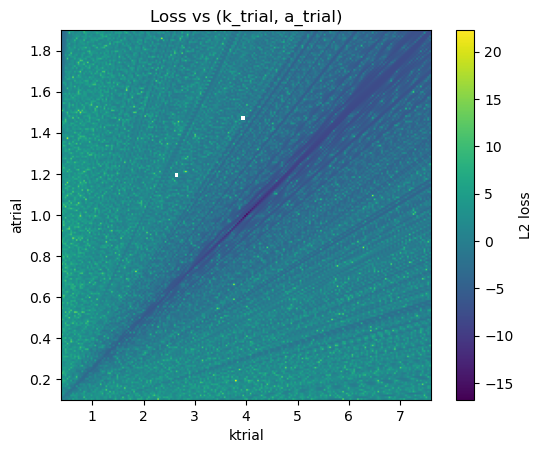

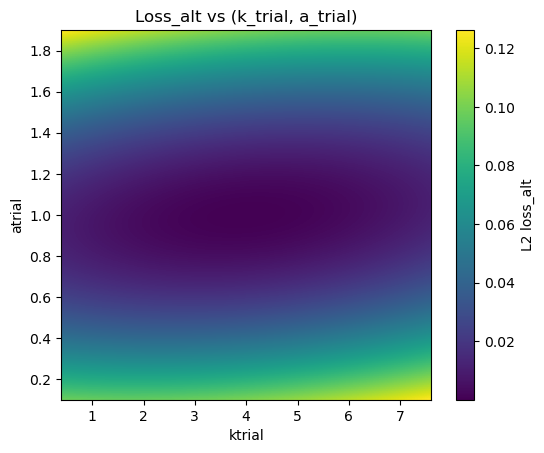

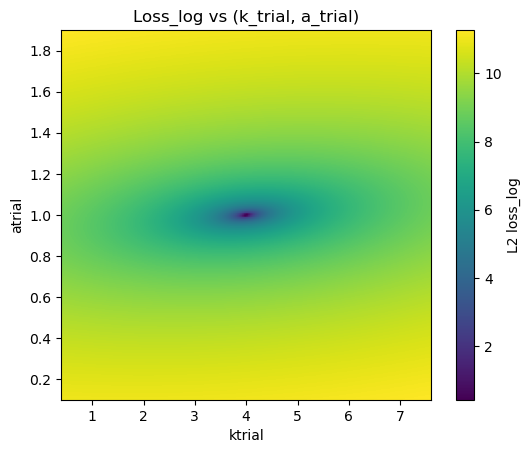

In [288]:
n_param_points_k = 200
n_param_points_a = 200
box_width_k = 0.90*k[0]
box_width_a = 0.90*alpha[0]

k_min = k[0] - box_width_k
k_max = k[0] + box_width_k
a_min = alpha[0] - box_width_a
a_max = alpha[0] + box_width_a

ktrialgrid = torch.linspace(k_min,k_max,n_param_points_k)
atrialgrid = torch.linspace(a_min,a_max,n_param_points_a)



def loss(q,qdot,m,k,alpha,dataset):
    test_qdd = QDDv(q,qdot,m,k,alpha)
    return torch.sum(( (test_qdd - dataset)**1 / torch.abs(test_qdd) )**2 )/(dataset.size()[0]**2)

def loss_alt(q,qdot,m,k,alpha,dataset):
    test_qdd = QDDv(q,qdot,m,k,alpha)
    return torch.sum(( (test_qdd - dataset) )**2 )/(dataset.size()[0]**2)

def loss_log(q,qdot,m,k,alpha,dataset):
    test_qdd = QDDv(q,qdot,m,k,alpha)
    return torch.log(torch.sum(( (test_qdd - dataset) )**2 ))

loss_mat = torch.zeros([n_param_points_k, n_param_points_a])
loss_alt_mat = torch.zeros([n_param_points_k, n_param_points_a])
loss_log_mat = torch.zeros([n_param_points_k, n_param_points_a])


sz = out.size(1)
qdd_trials = torch.zeros(sz)

for i in tqdm.trange(n_param_points_k): #iterate over m
    ktrial = tensor([ktrialgrid[i]], requires_grad = True) #pick k_trial value from grid
    for j in range(n_param_points_a): #iterate over k
        atrial = tensor([atrialgrid[j]], requires_grad = True) #pick a_trial value from grid

        #qdd_trials = QDDv(Q,QD,mtrial,ktrial,alpha)
        
        #loss_mat[i,j] = torch.sum( (qdd_trials - out)**2 )/sz #calculate loss function
        loss_mat[i,j] = loss(Qv,QDv,m,ktrial,atrial,out)
        loss_alt_mat[i,j] = loss_alt(Qv,QDv,m,ktrial,atrial,out)
        loss_log_mat[i,j] = loss_log(Qv,QDv,m,ktrial,atrial,out)




print(f"The original parameters are m = {m[0]}, k = {k[0]}")

#plotting
#fig, axs = plt.subplots(3,1,figsize=(15,15))
plt.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
plt.xlabel('ktrial')
plt.ylabel('atrial')
plt.colorbar(label='L2 loss')
plt.title("Loss vs (k_trial, a_trial)")
plt.show()

plt.imshow((loss_alt_mat.detach().numpy().T+1e-12), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
plt.xlabel('ktrial')
plt.ylabel('atrial')
plt.colorbar(label='L2 loss_alt')
plt.title("Loss_alt vs (k_trial, a_trial)")
plt.show()

plt.imshow((loss_log_mat.detach().numpy().T), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
plt.xlabel('ktrial')
plt.ylabel('atrial')
plt.colorbar(label='L2 loss_log')
plt.title("Loss_log vs (k_trial, a_trial)")
plt.show()



***Numerical instability***

Here I visualize the numerical instability of the relative error squared loss function. Note the severe noise on the predicted $\ddot{q}$.

Comparing the loss vs. $\alpha$ curves for several values of $k$ reveals the existence of a whole forest of local minima for the optimizer to get trapped in, coming from the previously mentioned numerical instability (rounding errors)."

100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


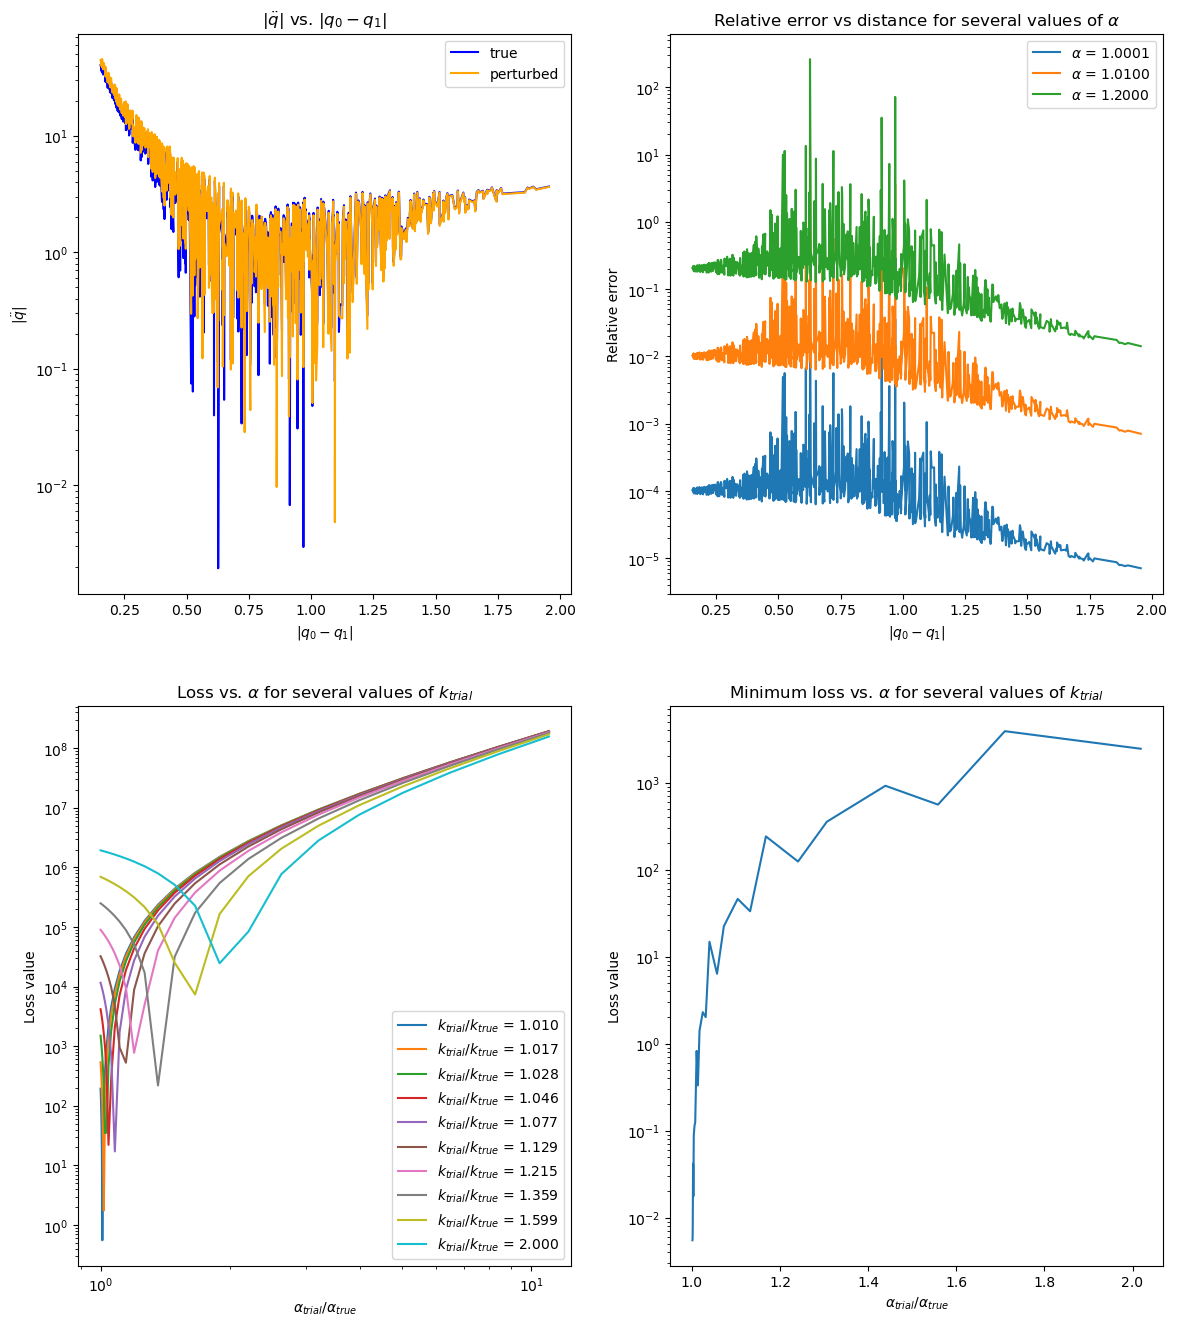

In [233]:
points_to_plot = 10000
if points_to_plot > n_points:
    points_to_plot = n_points

Q_mags, indices = torch.sort(torch.abs(Qv[:points_to_plot,0]-Qv[:points_to_plot,1]))
out_vals = out[:points_to_plot,0]
out_vals = out_vals[indices].detach()

test_vals = QDDv(Qv,QDv,m,k,alpha*1.1)[:points_to_plot,0]
test_vals = test_vals[indices]

fig, axs = plt.subplots(2,2,figsize=(14,16))

axs[0,0].plot(Q_mags,(torch.abs(out_vals)),color='blue',label='true')
axs[0,0].plot(Q_mags,(torch.abs(test_vals)),color='orange',label='perturbed')
axs[0,0].legend()
axs[0,0].set_xlabel(r'$|q_0-q_1|$')
axs[0,0].set_ylabel(r'$|\ddot{q}|$')
axs[0,0].set_yscale('log')
axs[0,0].set_title(r'$|\ddot{q}|$ vs. $|q_0-q_1|$')


a_trials = tensor([1.0001, 1.01, 1.2])

for i in range(a_trials.size()[0]):
    test_vals = QDDv(Qv,QDv,m,k,a_trials[i])[:points_to_plot,0]
    test_vals = test_vals[indices]
    axs[0,1].plot(Q_mags, abs((out_vals - test_vals)/out_vals),label=r'$\alpha$' + f' = {a_trials[i]:.4f}' )

axs[0,1].set_xlabel(r'$|q_0-q_1|$')
axs[0,1].set_ylabel('Relative error')
axs[0,1].set_yscale('log')
axs[0,1].set_title(r'Relative error vs distance for several values of $\alpha$')
axs[0,1].legend()

###
# calculate and plot loss vs. alpha for several values of k
a_powers = torch.linspace(-12,1,100)
a_trials = alpha[0] * (1+ 10**a_powers)
k_powers = torch.linspace(-2,0,10)
k_trials = k[0] * (1+10**k_powers)

loss_array = torch.zeros(a_trials.size()[0])
loss_min = torch.zeros(k_trials.size()[0])
loss_min_a = torch.zeros(k_trials.size()[0])

for j in tqdm.trange(k_trials.size()[0]):
    for i in range(a_trials.size()[0]):
        test_vals = QDDv(Qv,QDv,m,k_trials[j],a_trials[i])
        loss_array[i] = sum(((out-test_vals)/out)**2)
    #loss_min[j] = torch.min(loss_array)
    #loss_min_a[j] = a_trials[loss_array == loss_min[j]]
    axs[1,0].plot(a_trials/alpha,loss_array,label=r'$k_{trial}/k_{true}$' + f' = {k_trials[j]/k[0]:.3f}' )
axs[1,0].set_xlabel(r'$\alpha_{trial} / \alpha_{true}$')
axs[1,0].set_ylabel('Loss value')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_title(r'Loss vs. $\alpha$ for several values of $k_{trial}$')
axs[1,0].legend()

a_powers = torch.linspace(-12,1,250)
a_trials = alpha[0] * (1+ 10**a_powers)
k_powers = torch.linspace(-3,0,25)
k_trials = k[0] * (1+10**k_powers)

loss_array = torch.zeros(a_trials.size()[0])
loss_min = torch.zeros(k_trials.size()[0])
loss_min_a = torch.zeros(k_trials.size()[0])

for j in tqdm.trange(k_trials.size()[0]):
    for i in range(a_trials.size()[0]):
        test_vals = QDDv(Qv,QDv,m,k_trials[j],a_trials[i])
        loss_array[i] = sum(((out-test_vals)/out)**2)
    loss_min[j] = torch.min(loss_array)
    loss_min_a[j] = a_trials[loss_array == loss_min[j]]

axs[1,1].plot(loss_min_a/alpha,loss_min,label=r'minimum loss vs. k_{trial}')
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel(r'$\alpha_{trial} / \alpha_{true}$')
axs[1,1].set_ylabel('Loss value')
axs[1,1].set_title(r'Minimum loss vs. $\alpha$ for several values of $k_{trial}$')

plt.show()

Next, I try running gradient descent for the relative error squared loss function. This fails entirely due to the loss landscape roughness, every initial condition tried gets trapped in local minima.

100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


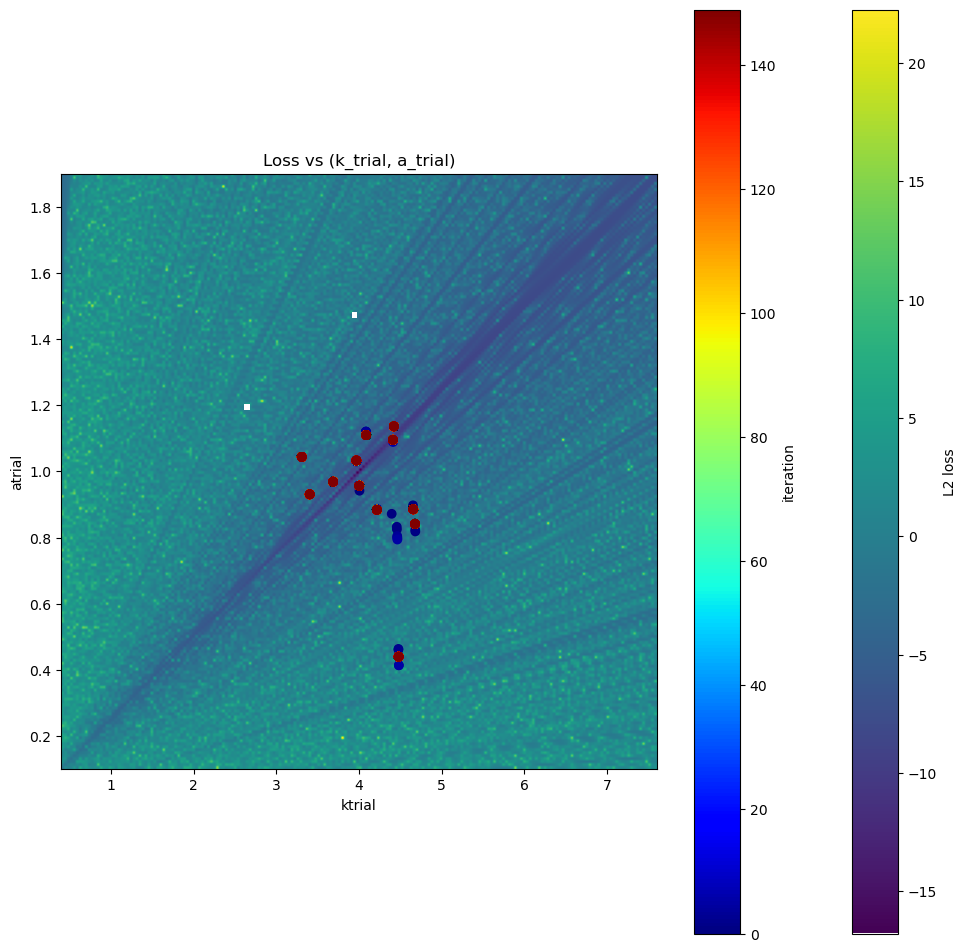

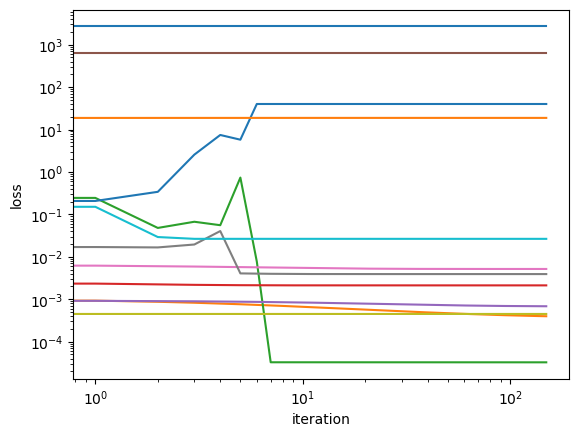

In [274]:
def loss(q,qdot,m,k,alpha,dataset):
    test_qdd = QDDv(q,qdot,m,k,alpha)
    return torch.sum(( (test_qdd - dataset)**1 / torch.abs(test_qdd) )**2 )/(dataset.size()[0]**2)

#####
# define gradient w.r.t. parameters
dlossdk = jacfwd(loss,argnums=3)
dlossda = jacfwd(loss,argnums=4)

n_trials = 12
trial_iters = 150
learning_rate = 1e-4

box_width_k_guess = 0.2*k[0]
box_width_a_guess = 0.2*alpha[0]

#plot loss landscape
fig, axs = plt.subplots(1,1,figsize=(12,12))

loss_bkgd = axs.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
axs.set_xlabel('ktrial')
axs.set_ylabel('atrial')
plt.colorbar(loss_bkgd, ax=axs,label='L2 loss')
axs.set_title("Loss vs (k_trial, a_trial)")

guess_k_array = torch.zeros([trial_iters,n_trials])
guess_a_array = torch.zeros([trial_iters,n_trials])
iter_array = torch.arange(0,trial_iters,1)
loss_hist = torch.zeros([trial_iters,n_trials])


guess_k = tensor([0])
guess_a = tensor([0])

guesses_k = box_width_k_guess*2*(torch.rand(n_trials)-0.5)+k[0]
guesses_a = box_width_a_guess*2*(torch.rand(n_trials)-0.5)+alpha[0]

for j in tqdm.trange(n_trials):
    guess_k = torch.clone(guesses_k[j])
    guess_a = torch.clone(guesses_a[j])
    for i in range(trial_iters):
        guess_k_array[i,j] = torch.clone(guess_k)
        guess_a_array[i,j] = torch.clone(guess_a)

        loss_hist[i,j] = loss(Qv,QDv,m,guess_k,guess_a,out)
        
        dldk = dlossdk(Qv,QDv,m,guess_k,guess_a,out)
        dlda = dlossda(Qv,QDv,m,guess_k,guess_a,out)
        d_tot = (dldk**2 + dlda**2)**.5
        d_scale = torch.exp(-(learning_rate*d_tot)**2)**1
        
        guess_k.data += -learning_rate*dldk*d_scale
        guess_a.data += -learning_rate*dlda*d_scale

        
        
points = axs.scatter(guess_k_array[:,0],guess_a_array[:,0],c=iter_array,cmap='jet')
if n_trials >= 2:
    for i in range(1,n_trials):
        axs.scatter(guess_k_array[:,i],guess_a_array[:,i],c=iter_array,cmap='jet')

plt.colorbar(points,ax=axs, label='iteration')
axs.set_xlim(left= (k[0] - box_width_k), right = k[0] + box_width_k)
axs.set_ylim(bottom=alpha[0] - box_width_a, top = alpha[0] + box_width_a)
plt.show()

plt.plot(iter_array,loss_hist[:,0].detach(),label='trial 0')
if n_trials >= 2:
    for i in range(1,n_trials):
        plt.plot(iter_array,loss_hist[:,i].detach(),label='trial {i}')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.show()

Here I perform gradient descent on the typical $L^2$ loss function. This has the best performance of any of these three loss functions.

100%|██████████| 25/25 [03:21<00:00,  8.08s/it]


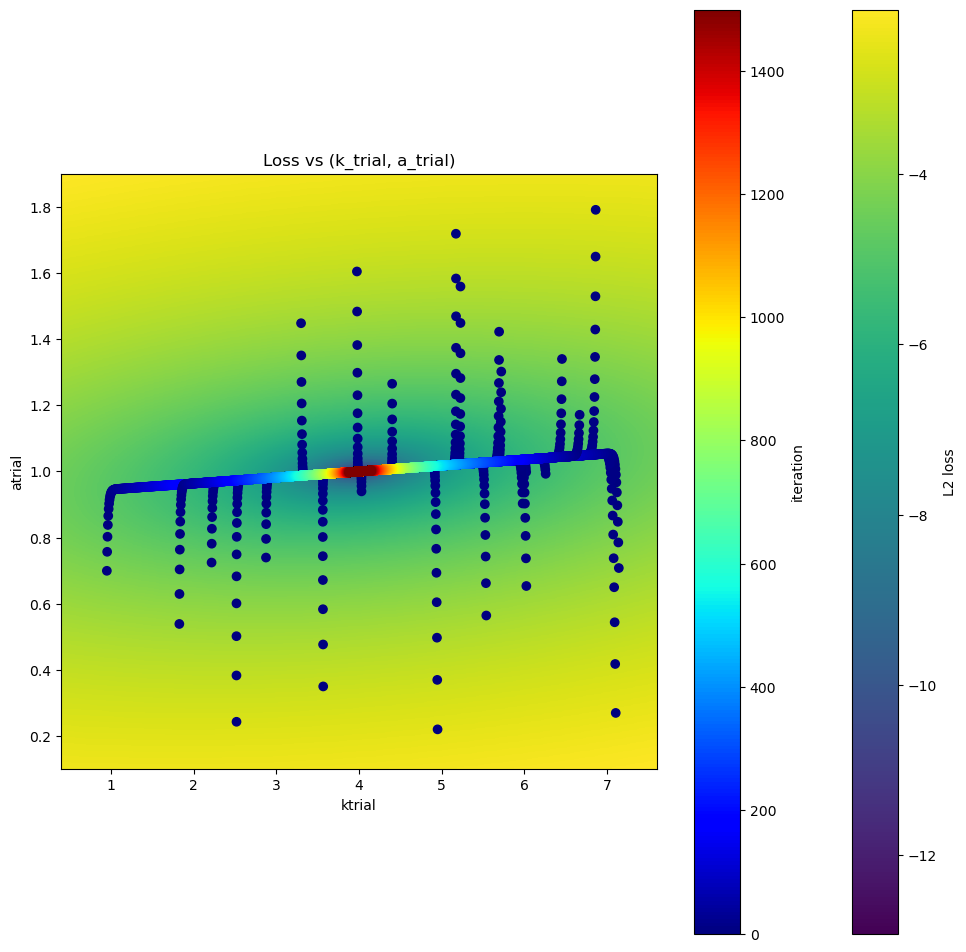

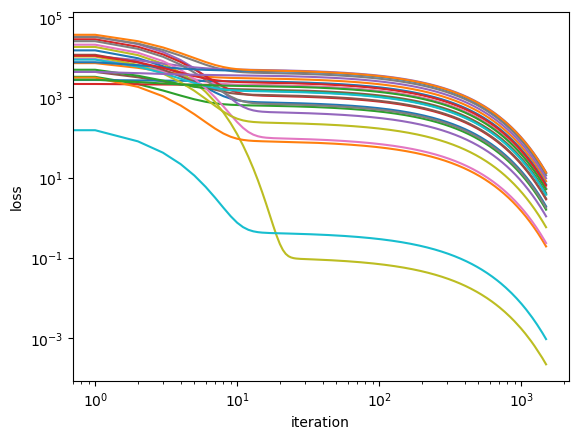

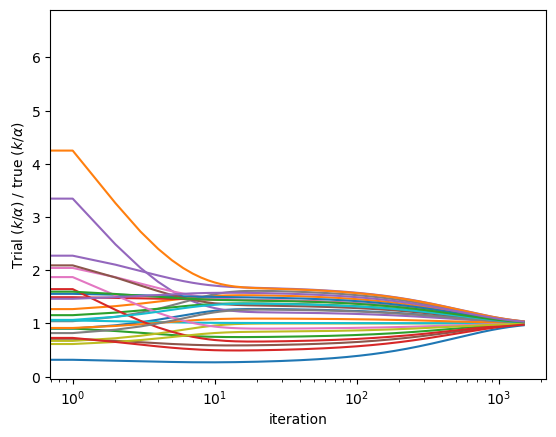

In [275]:
def loss_alt(q,qdot,m,k,alpha,dataset):
    test_qdd = QDDv(q,qdot,m,k,alpha)
    return torch.sum(( (test_qdd - dataset) )**2 )

#####
# define gradient w.r.t. parameters
dlossdk_alt = jacrev(loss_alt,argnums=3)
dlossda_alt = jacrev(loss_alt,argnums=4)

n_trials = 25
trial_iters = 1500
learning_rate = 2e-6

box_width_k_guess = 0.8*k[0]
box_width_a_guess = 0.8*alpha[0]

out_w_grad = out
out_w_grad.requires_grad = True

#plot loss landscape
fig, axs = plt.subplots(1,1,figsize=(12,12))

loss_bkgd = axs.imshow(np.log(loss_alt_mat.detach().numpy().T+1e-12), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
axs.set_xlabel('ktrial')
axs.set_ylabel('atrial')
plt.colorbar(loss_bkgd, ax=axs,label='L2 loss')
axs.set_title("Loss vs (k_trial, a_trial)")

guess_k_array = torch.zeros([trial_iters,n_trials])
guess_a_array = torch.zeros([trial_iters,n_trials])
iter_array = torch.arange(0,trial_iters,1)
loss_hist = torch.zeros([trial_iters,n_trials])


guess_k = tensor([0])
guess_a = tensor([0])

guesses_k = box_width_k_guess*2*(torch.rand(n_trials)-0.5)+k[0]
guesses_a = box_width_a_guess*2*(torch.rand(n_trials)-0.5)+alpha[0]

for j in tqdm.trange(n_trials):
    guess_k = torch.clone(guesses_k[j])
    guess_a = torch.clone(guesses_a[j])
    for i in range(trial_iters):
        guess_k_array[i,j] = torch.clone(guess_k)
        guess_a_array[i,j] = torch.clone(guess_a)

        loss_hist[i,j] = loss_alt(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        
        dldk = dlossdk_alt(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        dlda = dlossda_alt(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        d_tot = (dldk**2 + dlda**2)**.5
        d_scale = torch.exp(-(learning_rate*d_tot)**.5)**1
        
        guess_k.data += -learning_rate*dldk*d_scale
        guess_a.data += -learning_rate*dlda*d_scale

        
        
points = axs.scatter(guess_k_array[:,0],guess_a_array[:,0],c=iter_array,cmap='jet')
if n_trials >= 2:
    for i in range(1,n_trials):
        axs.scatter(guess_k_array[:,i],guess_a_array[:,i],c=iter_array,cmap='jet')

plt.colorbar(points,ax=axs, label='iteration')
axs.set_xlim(left= (k[0] - box_width_k), right = k[0] + box_width_k)
axs.set_ylim(bottom=alpha[0] - box_width_a, top = alpha[0] + box_width_a)

plt.show()

loss_hist = loss_hist.detach().numpy()

plt.plot(iter_array,loss_hist[:,0],label='trial 0')
if n_trials >= 2:
    for i in range(1,n_trials):
        plt.plot(iter_array,loss_hist[:,i],label=f'trial {i}')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.show()

plt.plot(iter_array,(guess_k_array/guess_a_array)[:,0]/(k[0]/alpha[0]),label='trial 0')
if n_trials >= 2:
    for i in range(1,n_trials):
        plt.plot(iter_array,(guess_k_array/guess_a_array)[:,i]/(k[0]/alpha[0]),label=f'trial {i}')
plt.xlabel('iteration')
plt.ylabel(r'Trial $(k/\alpha)$ / true $(k/\alpha)$')
plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.show()

Here I perform gradient descent on the $\log(L^2)$ loss function. Generally, most initial conditions appear to be converging towards the correct parameters, but very slowly. 

Compared to the standard $L^2$ loss function, this function produces much wilder failures when the learning rate becomes too large. Instead of mild oscillations, it produces wild swings around the minima that can be as large as ~10%.

Some initial conditions also appear to diverge away from the true parameter values, I'm not sure why.

100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


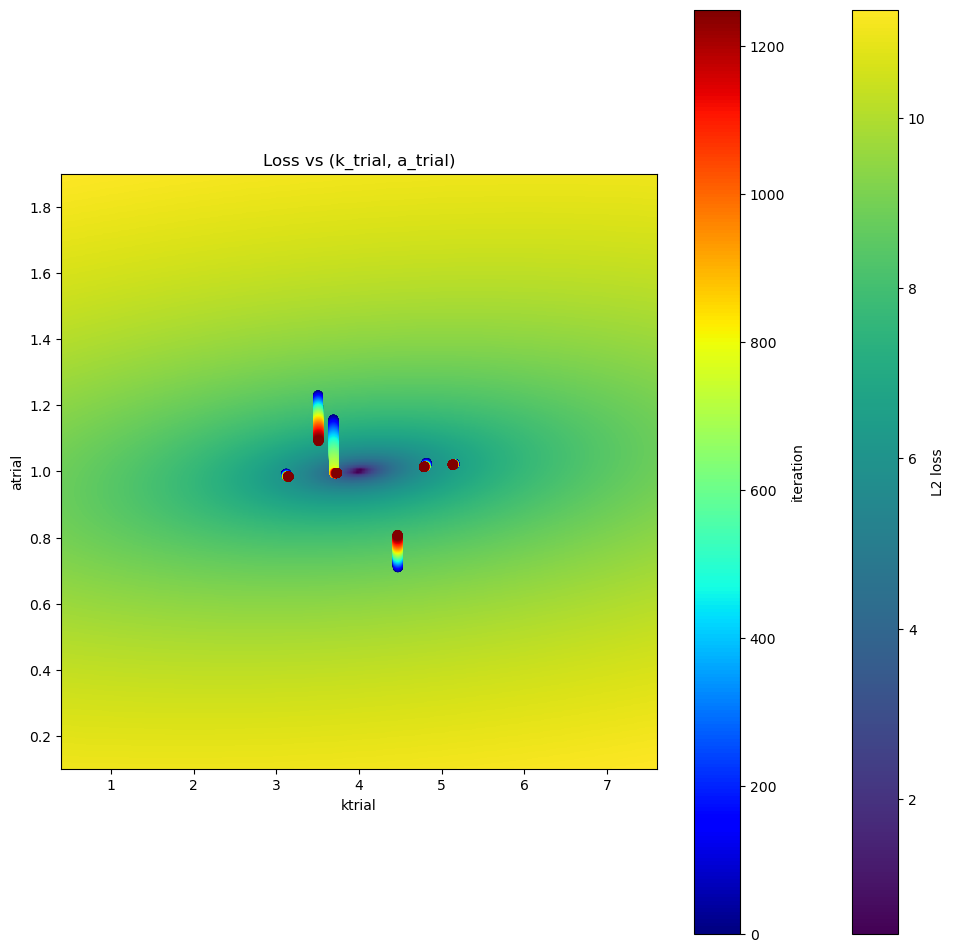

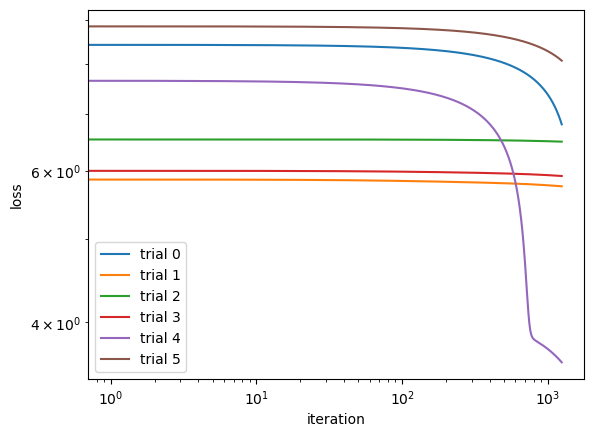

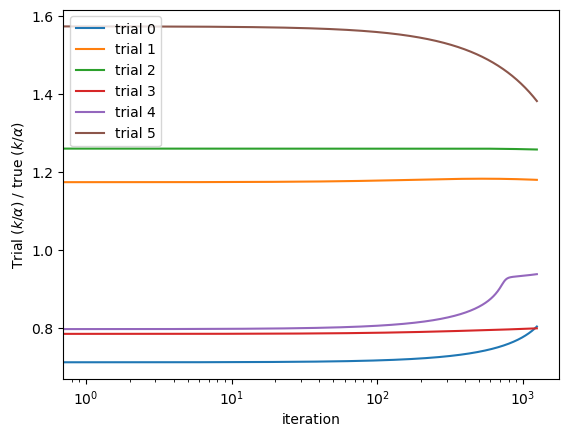

In [276]:
def loss_log(q,qdot,m,k,alpha,dataset):
    test_qdd = QDDv(q,qdot,m,k,alpha)
    return torch.log(torch.sum(( (test_qdd - dataset) )**2 ))

#####
# define gradient w.r.t. parameters
dlossdk_log = jacrev(loss_log,argnums=3)
dlossda_log = jacrev(loss_log,argnums=4)

n_trials = 6
trial_iters = 1250
learning_rate = 1e-5

box_width_k_guess = 0.3*k[0]
box_width_a_guess = 0.3*alpha[0]

out_w_grad = out
out_w_grad.requires_grad = True

#plot loss landscape
fig, axs = plt.subplots(1,1,figsize=(12,12))

loss_bkgd = axs.imshow((loss_log_mat.detach().numpy().T+1e-12), extent=[k_min,k_max,a_min,a_max],origin='lower',aspect=box_width_k/box_width_a)
axs.set_xlabel('ktrial')
axs.set_ylabel('atrial')
plt.colorbar(loss_bkgd, ax=axs,label='L2 loss')
axs.set_title("Loss vs (k_trial, a_trial)")

guess_k_array = torch.zeros([trial_iters,n_trials])
guess_a_array = torch.zeros([trial_iters,n_trials])
iter_array = torch.arange(0,trial_iters,1)
loss_hist = torch.zeros([trial_iters,n_trials])


guess_k = tensor([0])
guess_a = tensor([0])

guesses_k = box_width_k_guess*2*(torch.rand(n_trials)-0.5)+k[0]
guesses_a = box_width_a_guess*2*(torch.rand(n_trials)-0.5)+alpha[0]

for j in tqdm.trange(n_trials):
    guess_k = torch.clone(guesses_k[j])
    guess_a = torch.clone(guesses_a[j])
    for i in range(trial_iters):
        guess_k_array[i,j] = torch.clone(guess_k)
        guess_a_array[i,j] = torch.clone(guess_a)

        loss_hist[i,j] = loss_log(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        
        dldk = dlossdk_log(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        dlda = dlossda_log(Qv,QDv,m,guess_k,guess_a,out_w_grad)
        d_tot = (dldk**2 + dlda**2)**.5
        d_scale = 1#torch.exp(-(learning_rate*d_tot)**.5)**1
        
        guess_k.data += -learning_rate*dldk*d_scale
        guess_a.data += -learning_rate*dlda*d_scale

        
        
points = axs.scatter(guess_k_array[:,0],guess_a_array[:,0],c=iter_array,cmap='jet')
if n_trials >= 2:
    for i in range(1,n_trials):
        axs.scatter(guess_k_array[:,i],guess_a_array[:,i],c=iter_array,cmap='jet')

plt.colorbar(points,ax=axs, label='iteration')
axs.set_xlim(left= (k[0] - box_width_k), right = k[0] + box_width_k)
axs.set_ylim(bottom=alpha[0] - box_width_a, top = alpha[0] + box_width_a)

plt.show()

loss_hist = loss_hist.detach().numpy()

plt.plot(iter_array,loss_hist[:,0],label='trial 0')
if n_trials >= 2:
    for i in range(1,n_trials):
        plt.plot(iter_array,loss_hist[:,i],label=f'trial {i}')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(iter_array,(guess_k_array/guess_a_array)[:,0]/(k[0]/alpha[0]),label='trial 0')
if n_trials >= 2:
    for i in range(1,n_trials):
        plt.plot(iter_array,(guess_k_array/guess_a_array)[:,i]/(k[0]/alpha[0]),label=f'trial {i}')
plt.xlabel('iteration')
plt.ylabel(r'Trial $(k/\alpha)$ / true $(k/\alpha)$')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()